<a href="https://colab.research.google.com/github/kbyshiro/CMAPSS_tasks/blob/main/LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ライブラリのインポート
シードの固定も

In [17]:
import os
import sys
sys.path.append('/content/drive/My Drive/CMAPSSData/library')
from fd_dataset import FD_Dataset 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
sns.set()
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/CMAPSSData', '/content/drive/My Drive/CMAPSSData', '/content/drive/My Drive/CMAPSSData', '/content/drive/My Drive/CMAPSSData', '/content/drive/My Drive/CMAPSSData', '/content/drive/My Drive/CMAPSSData', '/content/drive/My Drive/CMAPSSData/library', '/content/drive/My Drive/CMAPSSData/library']


## データのロード&前処理

In [15]:
fd = FD_Dataset()
fd.load(data_id=1)
fd.MinMaxNorm()

RULに蓋をする(130で制限)

In [18]:
# RULに制限を設ける。
RUL_limit = 130
fd.LimitRUL(RUL_limit=RUL_limit)

## データローダーの準備

In [19]:
#tuning parameters
window_size = 30
batch_size = 100
cut_size = 10

In [20]:
train = fd.SlideWindow(fd.train, window_size, cut_size)
test = fd.SlideWindow(fd.test, window_size, cut_size)
dataloader = torch.utils.data.DataLoader(train, batch_size= batch_size)

In [22]:
train.X.size()

torch.Size([17631, 10, 3, 14])

## 学習モデルの構築
LSTM1(以後L1)とCNN層(以後C1）を並列で学習させ、
それをLSTM2(L2）でそれぞれsumしたものを通し、最後に全結合層で出力する。

In [24]:
#tuning parameters
L1_input_size= train.X.shape[2]*train.X.shape[3]
L1_hidden_size = 21

conv_size = [3, 2]
conv_stride = [2, 2]
conv_out_size = 3
maxpool_size = [1, 2]
maxpool_stride = [1, 2]

L2_input_size = L1_hidden_size
L2_hidden_size = 10
output_size = 1

In [25]:
class DAG_CNN_LSTM_Regressor(nn.Module):
  def __init__(self,L1_input_size, L1_hidden_size, conv_size, 
              conv_stride, maxpool_size, maxpool_stride, L2_input_size, L2_hidden_size, output_size):
    super().__init__()
    #L1
    self.L1_input_size = L1_input_size
    self.L1_hidden_size = L1_hidden_size
    self.LSTM1 = nn.LSTM(self.L1_input_size, self.L1_hidden_size)

    # CNN
    self.conv_size = conv_size
    self.conv_stride = conv_stride
    self.conv_out_size = conv_out_size
    self.maxpool_size = maxpool_size
    self.maxpool_stride = maxpool_stride
    self.CNN = nn.Sequential(nn.Conv2d(1, self.conv_out_size, kernel_size=self.conv_size,
                                       stride=self.conv_stride, padding=[1, 1]), 
                              nn.MaxPool2d(self.maxpool_size, self.maxpool_stride), 
                              nn.Flatten())

    #L2
    self.L2_input_size = L2_input_size
    self.L2_hidden_size = L2_hidden_size
    self.LSTM2 = nn.LSTM(self.L2_input_size, self.L2_hidden_size)

    # fully connected layer
    self.output_size = output_size
    self.Linear = nn.Linear(self.L2_hidden_size, self.output_size)
  
  def init_hidden(self, batch_size):
        hidden_state1 = torch.zeros(1, batch_size, self.L1_hidden_size)
        cell_state1 = torch.zeros(1, batch_size, self.L1_hidden_size)
        self.hidden1 = (hidden_state1, cell_state1)
        hidden_state2 = torch.zeros(1, batch_size, self.L2_hidden_size)
        cell_state2 = torch.zeros(1, batch_size, self.L2_hidden_size)
        self.hidden2 = (hidden_state2, cell_state2)


  def forward(self, x):
    batch_size, seq_size, width, n_features = x.size()

    #LSTM1
    #input size = (seq_size, batch_size, width*n_features)
    #output_size = (seq_size, batch_size, hidden_size)
    out1, self.hidden1 = self.LSTM1(torch.transpose(x, 0, 1).reshape(seq_size, batch_size, -1), self.hidden1)
    
    #CNN
    #input size = (seq_size, 1, n_features, width)
    #output_size = (seq_size, batch_size, hidden_size)
    out2 = torch.zeros((batch_size,seq_size, self.L1_hidden_size ))
    for i in range(batch_size):
      out2[i] = self.CNN(x[i].view(seq_size, 1, n_features, width))
    # print(out2.size())
    
    # combine outputs
    out = out1+ torch.transpose(out2, 0, 1)
    #LSTM2
    _, self.hidden2 = self.LSTM2(out, self.hidden2)
    
    #fully connecter
    out = self.Linear(self.hidden2[0][0].view(batch_size, -1))
    return out

## 訓練開始！


In [26]:
# training epoches

n_epoches = 100

In [27]:
#training
model = DAG_CNN_LSTM_Regressor(L1_input_size, L1_hidden_size, conv_size, 
                     conv_stride, maxpool_size, maxpool_stride, L2_input_size, L2_hidden_size, output_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.005)
RMSE_his = []
for epoch in range(n_epoches):
    loss_all = []
    for i, data in enumerate(dataloader):
        x_batch, y_batch = data
        optimizer.zero_grad()
        model.init_hidden(len(x_batch))
        #calc 
        y_pred = model(x_batch)
        loss = loss_fn(y_pred.view(-1), y_batch)
        loss_all.append(loss.item())
        # update
        loss.backward()
        optimizer.step()
    RMSE_his.append(np.sqrt(sum(loss_all)/len(loss_all)))
    if epoch%10 == 9:
        print('epoch: {0:3}: RMSE: {1:10.8f}'.format(epoch+1, RMSE_his[epoch]))
print('Done!')

epoch:  10: RMSE: 46.58376583
epoch:  20: RMSE: 43.46076942
epoch:  30: RMSE: 43.45394766
epoch:  40: RMSE: 23.75683506
epoch:  50: RMSE: 21.97392612
epoch:  60: RMSE: 20.76111311
epoch:  70: RMSE: 20.47065114
epoch:  80: RMSE: 20.32291444
epoch:  90: RMSE: 20.20406616
epoch: 100: RMSE: 20.09013439
Done!


In [28]:
y_true = test.t
with torch.no_grad():
    model.init_hidden(test.X.size(0))
    y_pred = model(test.X)
    mseloss = loss_fn(y_pred.view(-1), y_true)
print('RMSE: {}'.format(np.sqrt(mseloss)))

RMSE: 20.325462341308594


## 結果の表示

Text(0, 0.5, 'RMSE')

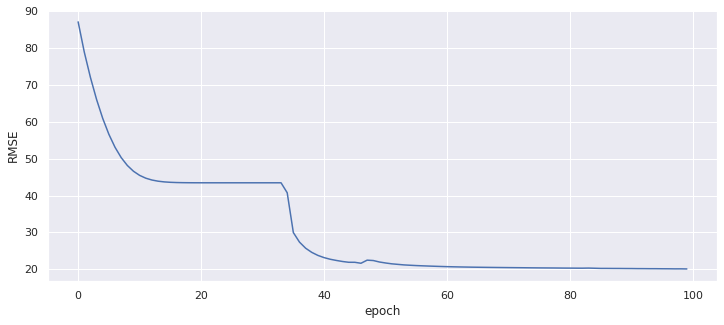

In [29]:
f = plt.figure(figsize=(12, 5))
plt.plot(RMSE_his, label='RMSE')
plt.xlabel('epoch')
plt.ylabel('RMSE')

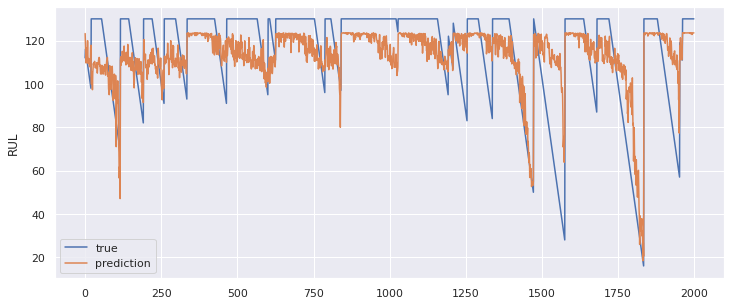

In [30]:
f= plt.figure(figsize=(12, 5))
plt.plot(y_true[:2000], label='true')
plt.plot(y_pred[:2000], label='prediction')
plt.ylabel('RUL')
plt.legend()

No handles with labels found to put in legend.


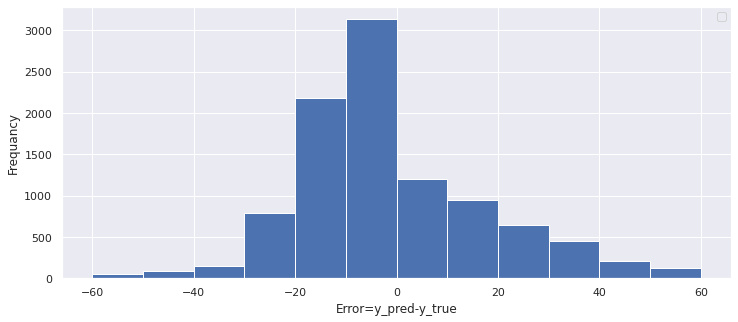

In [31]:
f= plt.figure(figsize=(12, 5))
plt.hist(y_pred.view(-1)-y_true, range=(-60, 60), bins=12)
plt.xlabel('Error=y_pred-y_true')
plt.ylabel('Frequancy')
plt.legend()